In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 25.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=4eeb3dcbd9d9ca5ef23785b3d88a4b1851f17f645b72663c2378759fe7e9760f
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [ ]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import seaborn as sns
from pyspark.sql.functions import mean
import  pyspark.sql.functions as F
from pyspark.sql.functions import sum, when

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Spark sSession is a entry point for the app
sc = SparkSession.builder.appName("das").getOrCreate()
df = sc.read.csv("/content/drive/MyDrive/credit/application_train.csv",header=True,inferSchema=True)
df.printSchema()  #it gives the insight about the data

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [ ]:
#let see the datframe using pandas
pd_dataframe = df.toPandas()
pd_dataframe.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#segerating the  numeric and categorical column
def segerate(df):
    num_col = []
    cat_col = []
    num_dtype = ['int','double']
    for cols in df.dtypes:
        if cols[1] in num_dtype:
            num_col.append(cols[0])
        else:
            cat_col.append(cols[0])
    return cat_col, num_col

cat_col, num_col = segerate(df)
print(str(len(num_col))+" numerical columns")
print(str(len(cat_col))+" categorical columns")
    


106 numerical columns
16 categorical columns


In [ ]:
#Findout the missing values 
# def missing_val(df,cat_col,num_col):
def check_na(df):
  na_list = []
  for i in df.columns:
    val = df.filter(df[i].isNull()).count()
    if val!=0:
      na_list.append([i,val])
  return na_list
    
missing_values = check_na(df)
print(missing_values)


[['AMT_ANNUITY', 12], ['AMT_GOODS_PRICE', 278], ['NAME_TYPE_SUITE', 1292], ['OWN_CAR_AGE', 202929], ['OCCUPATION_TYPE', 96391], ['CNT_FAM_MEMBERS', 2], ['EXT_SOURCE_1', 173378], ['EXT_SOURCE_2', 660], ['EXT_SOURCE_3', 60965], ['APARTMENTS_AVG', 156061], ['BASEMENTAREA_AVG', 179943], ['YEARS_BEGINEXPLUATATION_AVG', 150007], ['YEARS_BUILD_AVG', 204488], ['COMMONAREA_AVG', 214865], ['ELEVATORS_AVG', 163891], ['ENTRANCES_AVG', 154828], ['FLOORSMAX_AVG', 153020], ['FLOORSMIN_AVG', 208642], ['LANDAREA_AVG', 182590], ['LIVINGAPARTMENTS_AVG', 210199], ['LIVINGAREA_AVG', 154350], ['NONLIVINGAPARTMENTS_AVG', 213514], ['NONLIVINGAREA_AVG', 169682], ['APARTMENTS_MODE', 156061], ['BASEMENTAREA_MODE', 179943], ['YEARS_BEGINEXPLUATATION_MODE', 150007], ['YEARS_BUILD_MODE', 204488], ['COMMONAREA_MODE', 214865], ['ELEVATORS_MODE', 163891], ['ENTRANCES_MODE', 154828], ['FLOORSMAX_MODE', 153020], ['FLOORSMIN_MODE', 208642], ['LANDAREA_MODE', 182590], ['LIVINGAPARTMENTS_MODE', 210199], ['LIVINGAREA_MODE',

In [ ]:
#creating the dataframen for the missing values
miss_df = pd.DataFrame(missing_values,columns=["Name","Value"])
miss_df.sort_values(by=["Value"],ascending=False)
miss_df.tail()

,Name,Value
62,AMT_REQ_CREDIT_BUREAU_DAY,41519
63,AMT_REQ_CREDIT_BUREAU_WEEK,41519
64,AMT_REQ_CREDIT_BUREAU_MON,41519
65,AMT_REQ_CREDIT_BUREAU_QRT,41519
66,AMT_REQ_CREDIT_BUREAU_YEAR,41519


In [ ]:
# #this is not working
# columns = ["name","val"]
# miss_df = sc.createDataFrame(miss_val)
# miss_df.show()

In [ ]:
#handling the missing value
print("dataframe shape before handling missing values",(df.count(),len(df.columns)))

#case1 drop the values from the dataframe
df_droppall = df.na.drop()
print("dataframe shape after handling missing values",(df_droppall.count(),len(df_droppall.columns)))

#so droping the column is not a good option


dataframe shape before handling missing values (307511, 122)
dataframe shape after handling missing values (8602, 122)


In [ ]:
#not working

# import numpy as np
# def find_median(val):
#   try:
#       median = np.median(pd_dataframe[[val]])
#       return round(float(median),2)
#   except Exception:
#     return None

# from pyspark.sql.types import FloatType
# medianUDF = F.udf(find_median,FloatType())
# df.withColumn("median",medianUDF('SK_ID_CURR')).show()


In [ ]:
#this method for handling the missing value is not working
# def dict_creator(num_col):
#   means = {}
#   for i in num_col:
#     means[i]= df.select(mean(i)).collect()
#   for i in means.keys():
#     val = str(means[i][0])
#     means[i] = float(val.split("=")[1].replace(")",""))
#   return means

# means = dict_creator(num_col)
# print(means)



# def find_median(num_col):
#   medians = {}
#   for i in num_col:
#     medians[i] = pd_dataframe[i].median()
#   return medians 

# medians = find_median(num_col)
# print(medians)



# def percent_diff(threshold,means,medians):
#   final_val = {}
#   for i in means.keys():
#     val1 = means[i]
#     val2 = medians[i]
#     if val2!=0:
#       ratio = abs(val2-val1)/val2
#     if ratio<threshold :
#       final_val[i] = val1
#     else:
#       final_val[i] = val2
#   return final_val

# final_val = percent_diff(0.5,means,medians)
# for i in num_col:
#   df.na.fill(final_val[i],i)
# df.show()

In [ ]:
#let try to remove the null values using Impute function
#first remove the null values for the numeric data
from pyspark.ml.feature import Imputer
def num_na_remove(df):
  imputer = Imputer(inputCols = num_col,
                    outputCols = ["{}_imputed".format(a) for a in num_col]).setStrategy("mean")
  df_num = imputer.fit(df).transform(df)
  return df_num

df_num = num_na_remove(df)
print("the shape of dataframe after imputation", (df_num.count(),len(df_num.columns)))

the shape of dataframe after imputation (307511, 228)


In [ ]:
#remove the repeated colum from the dataframe
df_num_updated = df_num.drop(*num_col)
df_num_updated.show()

+------------------+-----------+------------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+---------------+--------------------------+--------------------+------------------+--------------+------------------+-------------------+------------------+--------------+--------------------+------------------------+------------------+-------------------+-----------------------+----------------------------------+------------------+---------------------+-------------------------+-----------------------+-------------------+------------------+----------------------+-----------------------+------------------------+------------------+------------------+-----------------------+----------------------------+-----------------------------------+-------------------------------+----------------------------------+----------------------------------+-----------------------------------+------------------------------+-----------------------------

In [ ]:
#removing the nan values for categorical feature from the dataframe
def cat_na_remove(cat_col,df_num_updated):
  modes = {}
  drop = []

  for i in cat_col:
    val =  df_num_updated.groupby(i).count().orderBy("count", ascending=False).first()[0]
    if val!=None:
      modes[i] = val
    else:
      drop.append(i)

  for i in modes:
    df_cat = df_num_updated.na.fill(modes[i],i)

  df_updated = df_cat.drop(*drop)
  return df_updated, modes 


df_updated,modes = cat_na_remove(cat_col,df_num_updated)
df_updated.show()


+------------------+-----------+------------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+--------------------+-------------------+------------------+--------------+--------------------+------------------------+------------------+-------------------+-----------------------+----------------------------------+------------------+---------------------+-------------------------+-----------------------+-------------------+------------------+----------------------+-----------------------+------------------------+------------------+------------------+-----------------------+----------------------------+-----------------------------------+-------------------------------+----------------------------------+----------------------------------+-----------------------------------+------------------------------+------------------------------+-------------------------------+--------------------+--------------

In [ ]:
print(modes)

{'NAME_CONTRACT_TYPE': 'Cash loans', 'CODE_GENDER': 'F', 'FLAG_OWN_CAR': 'N', 'FLAG_OWN_REALTY': 'Y', 'NAME_TYPE_SUITE': 'Unaccompanied', 'NAME_INCOME_TYPE': 'Working', 'NAME_EDUCATION_TYPE': 'Secondary / secondary special', 'NAME_FAMILY_STATUS': 'Married', 'NAME_HOUSING_TYPE': 'House / apartment', 'WEEKDAY_APPR_PROCESS_START': 'TUESDAY', 'ORGANIZATION_TYPE': 'Business Entity Type 3', 'EMERGENCYSTATE_MODE': 'No'}


In [ ]:
print(check_na(df_updated))
df_updated = df_updated.na.fill( 'Unaccompanied','NAME_TYPE_SUITE')
print(check_na(df_updated))


[['NAME_TYPE_SUITE', 1292]]
[]


In [ ]:
#remove the null values from the categorical data
# imputer_cat = Imputer(inputCols =,
#                   outputCols = ["{}_imputed".format(a) for a in modes.keys()]).setStrategy("mode")
# df_cat = imputer_cat.fit(df_num_updated).transform(df_num_updated)
# print("the shape of dataframe after imputation", (df_cat.count(),len(df_cat.columns)))

In [ ]:
#drop the unuseful function 


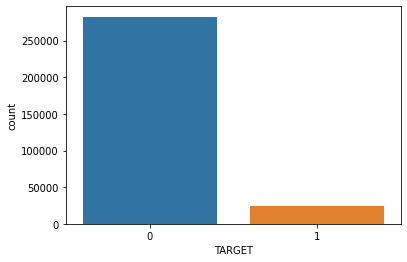

In [ ]:
#check for the class imbalance in dataframe
sns.countplot(x = pd_dataframe["TARGET"])  


In [ ]:
#obtaining the column weights to handle class imbalance
#creating a function to obtained the ratio for weighted loss function

def weighted_fun(df,i):
  datafrme = df.groupby(i).count().orderBy("count")
  val1 = datafrme.collect()[0]["count"]
  val2  = datafrme.collect()[1]["count"]
  summation = val1+val2
  ration_maj = val1/summation
  ration_min = val2/summation
  return round(ration_min,3),round(ration_maj,3)
min,maj = weighted_fun(df_updated,"TARGET_imputed")


def weighted_col(i,min,maj):
  return when(i==1,min).otherwise(1*maj)
df_updated = df_updated.withColumn("weights",weighted_col(col("TARGET_imputed"),min,maj))

In [ ]:
new_numcol = []
new_catcol = []
for i in df_updated.dtypes:
  if i[1]=="string":
    new_catcol.append(i[0])
  else:
    new_numcol.append(i[0])
new_numcol.remove("TARGET_imputed")
new_numcol.remove("weights")
print(new_catcol)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']


In [ ]:
#encoding the categorical values
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
stages = []
input_cat = []
for categorical_fet in new_catcol:
  labelencoder = StringIndexer(inputCol = categorical_fet,outputCol = categorical_fet+"Index" )
  onehotencoder = OneHotEncoder(inputCols = [labelencoder.getOutputCol()],outputCols =[categorical_fet+"_vec"] )
  stages += [labelencoder,onehotencoder]
  input_cat.append(categorical_fet+"_vec")
  
inputs = input_cat+new_numcol
assemble = VectorAssembler(inputCols = inputs,outputCol = "features")
stages += [assemble]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipeline_model = pipeline.fit(df_updated)
new_df = pipeline_model.transform(df_updated)


In [ ]:
cols = df_updated.columns
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)
new_df = new_df.withColumnRenamed("TARGET_imputed","label")

#splting the dataframe
train,test = new_df.randomSplit([0.7,0.3],seed = 2018)


In [ ]:
from pyspark.ml.classification import LogisticRegression
lr_model = LogisticRegression(featuresCol = "features",labelCol = "label",maxIter=15)
lr = lr_model.fit(train)

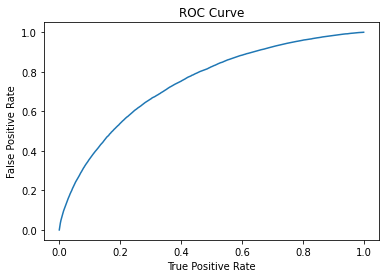

Training set ROC: 0.744799441193216


In [ ]:
import matplotlib.pyplot as plt
summary = lr.summary
roc  = summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(summary.areaUnderROC))

In [ ]:
#evaluating Logistic Regression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predict = lr.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test SET ROC: " + str(evaluator.evaluate(predict, {evaluator.metricName: "areaUnderROC"})))




Test SET ROC: 0.7466475050473289


In [ ]:
#Random forest
from pyspark.ml.classification import RandomForestClassifier
forest = RandomForestClassifier(featuresCol="features",labelCol = "label")
model_fr = forest.fit(train)

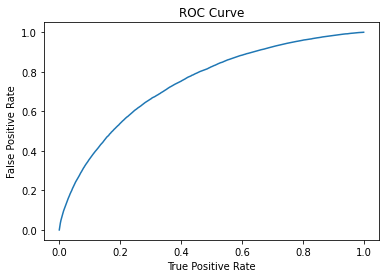

Training set ROC: 0.744799441193216


In [ ]:
summary_fr = lr.summary
roc  = summary_fr.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(summary_fr.areaUnderROC))

In [ ]:
#evaluating the Random forest
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predict = model_fr.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test SET ROC: " + str(evaluator.evaluate(predict, {evaluator.metricName: "areaUnderROC"})))



In [ ]:
#Train the gradient boost
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol = 'label',featuresCol = 'features',maxIter = 10)
gbt_model = gbt.fit(train)

In [ ]:
#evaluate the gradient boost model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predict = gbt_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test SET ROC: " + str(evaluator.evaluate(predict, {evaluator.metricName: "areaUnderROC"})))
